In [1]:
import pandas as pd
import numpy as np
import os
import pickle

# use to connect to Google Drive if running on Google Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# point to your project directory
endo_dir = '/content/drive/MyDrive/endometriosis/'
# replace with the name of your dataset file
file_path = os.path.join(endo_dir, 'data', 'endo+endometriosis.pkl')

df = pd.read_pickle(file_path)

In [3]:
output_path = os.path.join(endo_dir, 'output', 'fightin-words', 'latex')

In [4]:
endo_text = df[df["subreddit"] == "Endo"].text.tolist()
endometriosis_text = df[df["subreddit"] == "endometriosis"].text.tolist()

In [5]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
stopwords = stopwords.words('english')

remove_from_stops = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'they', 'them', 'their', 'theirs', 'themselves','he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']

stopwords_best = [token for token in stopwords if token not in remove_from_stops]
print(stopwords_best)

import string
exclude = set(string.punctuation)
from sklearn.feature_extraction.text import CountVectorizer as CV

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''
    return_string = ''.join([char for char in in_string if ord(char) < 128 and char not in exclude]).lower()
    return_string = ' '.join([word for word in return_string.split() if word not in stopwords_best])
    return return_string

def bayes_compare_language(l1, l2, output_path, ngram=1, prior=.01, cv=None, sig_val=2.573):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.
    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]

    if cv is None:
        cv = CV(
            decode_error = 'ignore', 
            min_df = .1, 
            max_df = .7, 
            ngram_range=(1,ngram),
            binary = False,
            max_features = 1500)
    counts_mat = cv.fit_transform(l1+l2).toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v: k for k, v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = [(index_to_term[i], z_scores[i]) for i in sorted_indices]
    

    # plotting z scores and frequencies
    x_vals = count_matrix.sum(axis=0)
    y_vals = z_scores
    sizes = abs(z_scores) * 2
    neg_color, pos_color, insig_color = ('#340509', '#053430', '#d8d8d8')
    colors = []
    annots = []
    for i, y in enumerate(y_vals):
        if y > sig_val:
            colors.append(pos_color)
            annots.append(index_to_term[i])
        elif y < -sig_val:
            colors.append(neg_color)
            annots.append(index_to_term[i])
        else:
            colors.append(insig_color)
            annots.append(None)

    
    fig, ax = plt.subplots(figsize=(14,20))
    ax.scatter(x_vals, y_vals, c=colors, linewidth=0, alpha = 0.3)

    for i, annot in enumerate(annots):
        if annot is not None:
            if (np.abs(y_vals[i]) > 2.573):
                ax.annotate(annot, (x_vals[i], y_vals[i]), color='black', alpha = 0.7, fontsize=12)

    ax.set_xscale('log')
    plt.xlabel("Word Frequency")
    plt.ylabel("z-score (log scale)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.savefig(os.path.join(output_path, 'fightin_words.png'), dpi = 300)

    return return_list, cv.vocabulary_

['it', "it's", 'its', 'itself', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocab size is 1500
Comparing language...


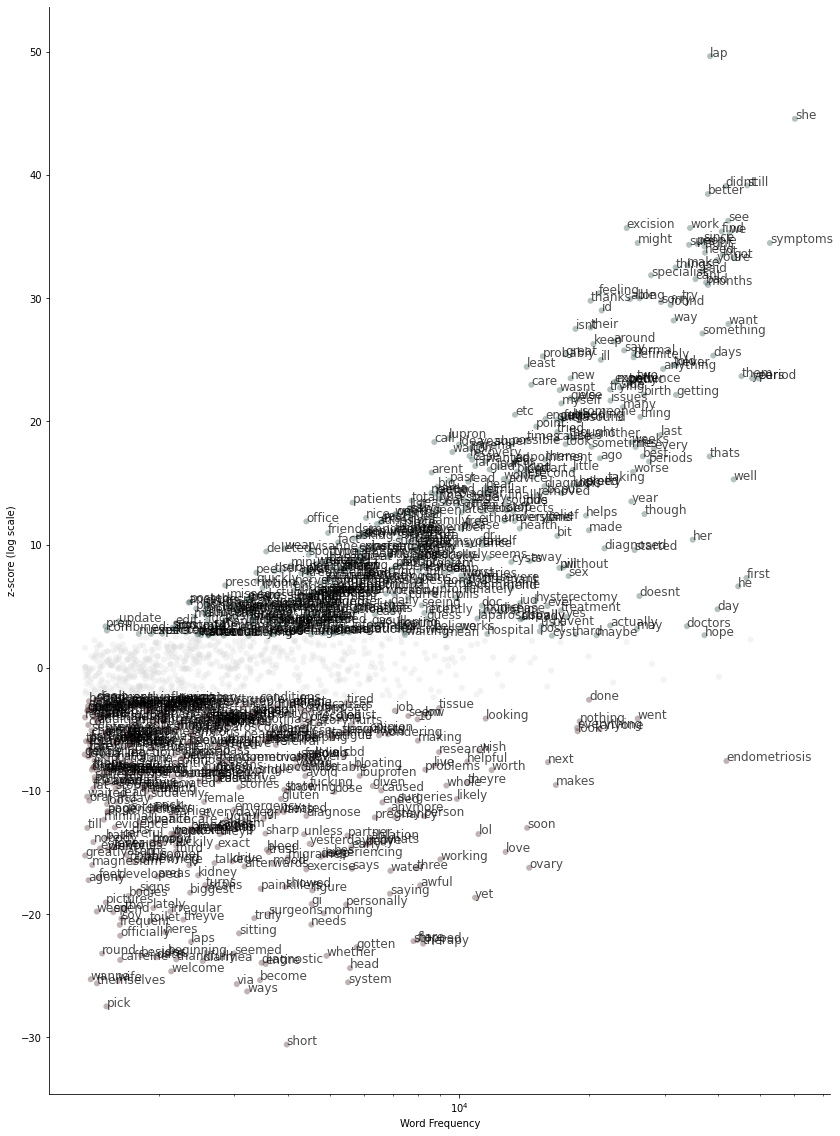

In [6]:
vectorizer = CV(decode_error = 'ignore', max_df = .10, min_df = 20, binary = False, max_features = 1500)  
vector = vectorizer.fit_transform(endo_text + endometriosis_text)

vector_prior = np.sum(vector, axis=0).astype(int)

vector_prior = np.squeeze(np.asarray(vector_prior))

output_list, vocabulary = bayes_compare_language(endo_text, endometriosis_text, output_path, prior=vector_prior, cv=vectorizer)


In [7]:
output_list[-100:]

[('mirena', 17.818770532541976),
 ('life', 17.924933446173895),
 ('sometimes', 17.936638842602626),
 ('super', 18.084305776308238),
 ('yeah', 18.117468490149818),
 ('idea', 18.12778473590287),
 ('took', 18.155742402542632),
 ('possible', 18.194524905879465),
 ('weeks', 18.31350960441545),
 ('call', 18.326735282588366),
 ('times', 18.489119056741494),
 ('cause', 18.531444840270474),
 ('ask', 18.618370179014573),
 ('lupron', 18.647577683608173),
 ('another', 18.762541005296985),
 ('thought', 18.815172770858545),
 ('last', 18.912860675355475),
 ('tried', 19.13687883461107),
 ('point', 19.58252906070167),
 ('ultrasound', 20.084881140646456),
 ('surgeon', 20.151337722196317),
 ('felt', 20.1938301367485),
 ('enough', 20.195532775772403),
 ('bleeding', 20.29034921380565),
 ('thing', 20.367587002953965),
 ('etc', 20.539641233658983),
 ('someone', 20.579202868836365),
 ('many', 21.163386936432754),
 ('myself', 21.46126996568814),
 ('issues', 21.684410130449454),
 ('else', 21.815893959171085),
 

In [35]:
# rendometriosis
df1 = pd.DataFrame(output_list[-50:], columns = ["Word", "z-score"]).round(2).sort_values(by = "z-score", ascending = False).reset_index(drop=True)#.to_latex(index=False)

In [37]:
df2 = pd.DataFrame(output_list[:50], columns = ["Word", "z-score"]).round(2)#.reset_index()#.to_latex(index=False)

In [38]:
dfs = [df1, df2]
latex_code = pd.concat(dfs, axis = 1).to_latex(index = False)

In [41]:
output_file = os.path.join(output_path, 'endo_vs_endometriosis.txt')

In [42]:
with open(output_file, 'w') as f:
    f.write(latex_code)

In [85]:
endo_pcos = pd.read_csv(os.path.join(output_path, '..', 'endometriosis-vs-pcos', 'z_scores_fightin_words.csv'))

In [86]:
endo_pcos = endo_pcos.rename(columns = {'0':'Word', '1': 'z-score'})

In [87]:
endo_pcos = endo_pcos.drop(columns = ['Unnamed: 0'])

In [88]:
endo_pcos

,Word,z-score
0,pcos,-75.001323
1,weight,-58.846420
2,hair,-49.724712
3,diet,-36.181709
4,acne,-35.222361
...,...,...
10150,pelvic,44.594791
10151,endometriosis,79.016171
10152,surgery,86.367750
10153,endo,105.607701


In [89]:
# rendometriosis
df1 = endo_pcos.tail(25).round(2).sort_values(by = "z-score", ascending = False).reset_index(drop=True)#.to_latex(index=False)

In [90]:
df2 = endo_pcos.head(25).round(2)#.reset_index()#.to_latex(index=False)

In [91]:
dfs = [df1, df2]
latex_code = pd.concat(dfs, axis = 1).to_latex(index = False)

In [92]:
output_file = os.path.join(output_path, 'endometriosis_vs_pcos.txt')

In [93]:
with open(output_file, 'w') as f:
    f.write(latex_code)